<a href="https://colab.research.google.com/github/Bhandari007/player-classfication/blob/main/Player_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Player Classification
>In this notebook, using different python library and packages, I'm going to build a model to predict the player corresponding club using the image of that player. There are 4 clubs in total given in the dataset namely Manchester City, Machester United and Liverpool
Since, the dataset is small and I'm going to use `transfer learning` for building the model.

# Problem Statement
>Given an image of the player, the model has to predict the name of the club that the player plays for

The steps followed are:-
1. Data Collection
2. Getting to know the data
3. Model Building
4. Model Evaluation
5. Iterating through Step 3 and Step 4 
6. Deployment

# 1. Data Collection

The images were downloaded from the google. One can download the dataset from the following link:<br>
 <a herf = "https://github.com/Bhandari007/player-classfication/blob/main/image_dataset.zip?raw=true">Dataset</a>

### Downloading dataset

In [ ]:
#!wget https://github.com/Bhandari007/player-classfication/blob/main/image_dataset.zip?raw=true

### Unzipping the Folder

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("image_dataset.zip")
zip_ref.extractall()
zip_ref.close()

# Getting to know the data

### No of images in each folder

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("image_dataset"):
  print(f"There are {len(filenames)} images in {dirpath} ")

There are 0 images in image_dataset 
There are 0 images in image_dataset/train 
There are 54 images in image_dataset/train/manchester_united 
There are 47 images in image_dataset/train/liverpool 
There are 45 images in image_dataset/train/manchester_city 
There are 0 images in image_dataset/test 
There are 21 images in image_dataset/test/machester_city 
There are 18 images in image_dataset/test/machester_united 
There are 19 images in image_dataset/test/liverpool 


### Create training and test directory paths


In [ ]:
train_dir = "image_dataset/train"
test_dir = "image_dataset/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 8


train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)
NUM_CLASS = len(train_data.class_names)

Found 145 files belonging to 3 classes.
Found 56 files belonging to 3 classes.


### Viewing the class names

In [ ]:
print(f"The classes are: {train_data.class_names}")

The classes are: ['liverpool', 'manchester_city', 'manchester_united']


### Plotting a random image

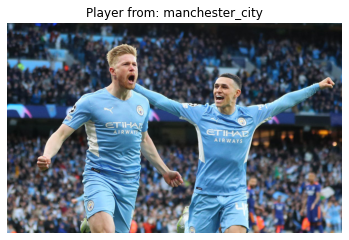

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

target_class = random.choice(train_data.class_names)
target_dir = "image_dataset/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Player from: {target_class}")
plt.axis(False);

# Model Building

In this section, I will try out different expirement so as to find out the model that fits the dataset. 

The series of expirements can be summarized as:-

* `model_0`: model building with [MobileNetV1](https://tfhub.dev/google/imagenet/mobilenet_v1_050_192/feature_vector/5) architecture
* `model_1`: model building with [EfficientNetB0](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) architecture
* `model_2`: model building with [EfficientNetB1](https://tfhub.dev/google/efficientnet/b1/feature-vector/1) architecture



### Setting up functions for conducting experimenets

#### URL of models

In [ ]:
net_v1_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_192/feature_vector/5"
efficient_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficient_net_b1_url  = "https://tfhub.dev/google/efficientnet/b1/feature-vector/1"

#### Setting up callback


In [ ]:
import datetime

def create_tensorboard_callbacks(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
import tensorflow_hub as hub

#### Function for building model

In [ ]:

def build_model(model_url):
  """
  Returns a keras model

  Arguments:
    model_url -- the url of the model to be built from the tensorflowhub website
    data_augmentation -- bool value
                        True (for adding data agumentation layer)
                        False(default [no data augmentation layer])
  Returns:
    model -- a keras sequential model
  """
  # Download the pretrained model and save it a keras layer
  tf.random.set_seed(42)
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMG_SIZE+(3,),
                                           )
  
  # Create model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(3, activation="softmax", name = "output_layer")
  ])

  return model

In [ ]:
IMG_SIZE + (3,)

(224, 224, 3)

#### Plotting the loss curves

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Model 0

### Creating MobileNetV1 model

In [ ]:
model_0 = build_model(net_v1_url)
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 512)              829536    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 831,075
Trainable params: 1,539
Non-trainable params: 829,536
_________________________________________________________________


### Compiling the net_v1_model

In [ ]:
model_0.compile(loss="categorical_crossentropy",
                                      optimizer = tf.keras.optimizers.Adam(),
                                      metrics = ["accuracy"])

### Fit the model 0

In [ ]:
tf.random.set_seed(42)
model_0_history = model_0.fit(train_data,
            epochs = 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data),
            callbacks = [create_tensorboard_callbacks(dir_name="tensorflow_hub",experiment_name="mobile_net_e1")])

Saving log files to: tensorflow_hub/mobile_net_e1/20221011-113400
Epoch 1/5
19/19 [==============================] - 7s 213ms/step - loss: 1.3427 - accuracy: 0.3310 - val_loss: 1.1611 - val_accuracy: 0.3750
Epoch 2/5
19/19 [==============================] - 4s 181ms/step - loss: 1.0172 - accuracy: 0.4621 - val_loss: 1.0315 - val_accuracy: 0.5000
Epoch 3/5
19/19 [==============================] - 4s 192ms/step - loss: 0.9328 - accuracy: 0.5655 - val_loss: 0.9887 - val_accuracy: 0.4821
Epoch 4/5
19/19 [==============================] - 4s 193ms/step - loss: 0.9126 - accuracy: 0.5586 - val_loss: 1.0091 - val_accuracy: 0.5000
Epoch 5/5
19/19 [==============================] - 4s 193ms/step - loss: 0.8391 - accuracy: 0.6138 - val_loss: 0.9833 - val_accuracy: 0.4464


### Plotting the loss curves

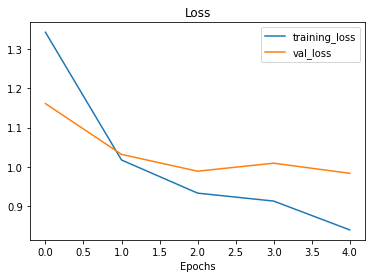

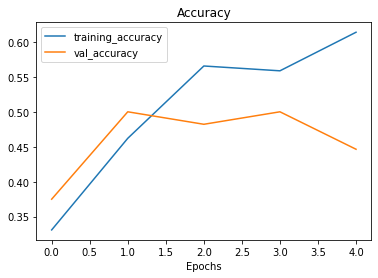

In [ ]:
plot_loss_curves(model_0_history)

### Conclusion
* Baseline accuracy ~ 100 %
* Training accuracy ~ 61%
* Validation accuracy ~ 44 %

We can conclude that the model 0 has high bias

To reduce high bias we can increase `training time (epochs)` or `choose a new architecture.`

## Option 0: Increase number of epochs

In [ ]:
model_0 = build_model(net_v1_url)
model_0.summary()
model_0.compile(loss="categorical_crossentropy",
                                      optimizer = tf.keras.optimizers.Adam(),
                                      metrics = ["accuracy"])
tf.random.set_seed(42)
model_0_history = model_0.fit(train_data,
            epochs = 20,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data),
            callbacks = [create_tensorboard_callbacks(dir_name="tensorflow_hub",experiment_name="mobile_net_e2")])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 512)              829536    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 831,075
Trainable params: 1,539
Non-trainable params: 829,536
_________________________________________________________________
Saving log files to: tensorflow_hub/mobile_net_e2/20221011-113458
Epoch 1/20
19/19 [==============================] - 6s 211ms/step - loss: 1.2485 - accuracy: 0.3931 - val_loss: 1.0966 - val_accuracy: 0.3929
Epoch 2/20
19/19 [==============================] - 4s 193ms/step - loss: 1.0203 - accuracy: 0.4897 - val_loss: 1.0316 - val_accuracy: 0.4821
Epoch 3/20
19/19 [======

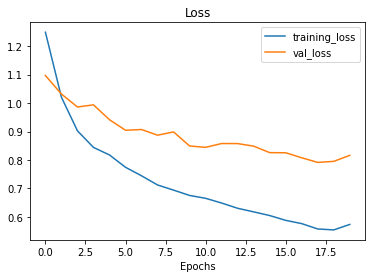

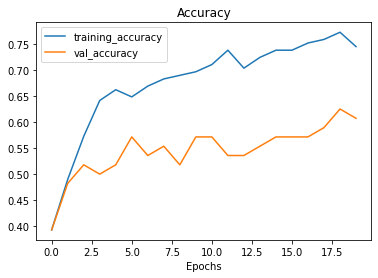

In [ ]:
plot_loss_curves(model_0_history)

### Conclusion
* Baseline accuracy ~ 100 %
* Training accuracy ~ 74%
* Validation accuracy ~ 60 %

The bias didnot decrease.


## Option 1: Select different Architecture

In [ ]:
model_1 = build_model(efficient_net_url)
model_1.summary()
model_1.compile(loss="categorical_crossentropy",
                                      optimizer = tf.keras.optimizers.Adam(),
                                      metrics = ["accuracy"])
tf.random.set_seed(42)
model_1_history = model_1.fit(train_data,
            epochs = 20,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data)
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 21s 622ms/step - loss: 345.3036 - accuracy: 0.2345 - val_loss: 314.4608 - val_accuracy: 0.4286
Epoch 2/20
19/19 [==============================] - 12s 611ms/step - loss: 143.2430 - accuracy: 0.4138 - val_loss: 385.4978 - val_accuracy: 0.3393
Epoch 3/20
19/19 [==============================] - 11s 563ms/step - loss: 7

### Conclusion

The model we fit has high variance.(overfitting problem)

We can increase the number of training set by data augmentation.

# Option 2: Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(height_factor=0.8,width_factor=1),
    tf.keras.layers.RandomContrast(0.2,0.5),
    tf.keras.layers.RandomRotation(0.2)
])

## Model 0: MobileNetV1

In [ ]:
model_0 = build_model(net_v1_url)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
test_ds = test_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

In [ ]:
model_0.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 512)              829536    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 4)                 2052      
                                                                 
Total params: 831,588
Trainable params: 2,052
Non-trainable params: 829,536
_________________________________________________________________


In [ ]:
model_0.compile(loss="categorical_crossentropy",
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam())

In [ ]:
model_0_history = model_0.fit(train_ds,
                              epochs = 20,
            steps_per_epoch = len(train_ds),
            validation_data = test_ds,
            validation_steps = len(test_ds) )

Epoch 1/20
19/19 [==============================] - 8s 276ms/step - loss: 1.2003 - accuracy: 0.4759 - val_loss: 1.1127 - val_accuracy: 0.4643
Epoch 2/20
19/19 [==============================] - 6s 256ms/step - loss: 0.9389 - accuracy: 0.5172 - val_loss: 0.9507 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 6s 255ms/step - loss: 0.8683 - accuracy: 0.6000 - val_loss: 0.8913 - val_accuracy: 0.5536
Epoch 4/20
19/19 [==============================] - 7s 323ms/step - loss: 0.7815 - accuracy: 0.6069 - val_loss: 0.8380 - val_accuracy: 0.5179
Epoch 5/20
19/19 [==============================] - 6s 261ms/step - loss: 0.7448 - accuracy: 0.6000 - val_loss: 0.6803 - val_accuracy: 0.6786
Epoch 6/20
19/19 [==============================] - 6s 261ms/step - loss: 0.7323 - accuracy: 0.6345 - val_loss: 0.6183 - val_accuracy: 0.6964
Epoch 7/20
19/19 [==============================] - 6s 259ms/step - loss: 0.6052 - accuracy: 0.7241 - val_loss: 0.8137 - val_accuracy: 0.5536
Epoch 

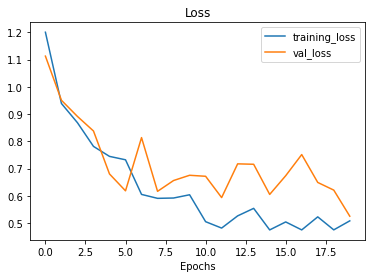

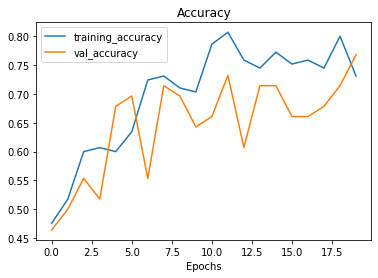

In [ ]:
plot_loss_curves(model_0_history)

* Training Accuracy: 73
* Validation Accuracy: 76

In [ ]:
model_1 = build_model(efficient_net_url)

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam())

In [ ]:
model_1_history = model_1.fit(train_ds,
                              epochs = 20,
            steps_per_epoch = len(train_ds),
            validation_data = test_ds,
            validation_steps = len(test_ds) )

Epoch 1/20
19/19 [==============================] - 21s 636ms/step - loss: 1.0490 - accuracy: 0.4414 - val_loss: 0.9368 - val_accuracy: 0.5179
Epoch 2/20
19/19 [==============================] - 12s 585ms/step - loss: 0.8136 - accuracy: 0.6138 - val_loss: 0.7686 - val_accuracy: 0.6964
Epoch 3/20
19/19 [==============================] - 11s 565ms/step - loss: 0.6893 - accuracy: 0.7034 - val_loss: 0.7427 - val_accuracy: 0.6607
Epoch 4/20
19/19 [==============================] - 12s 596ms/step - loss: 0.6802 - accuracy: 0.6759 - val_loss: 0.7456 - val_accuracy: 0.6964
Epoch 5/20
19/19 [==============================] - 11s 556ms/step - loss: 0.6253 - accuracy: 0.7586 - val_loss: 0.6167 - val_accuracy: 0.6964
Epoch 6/20
19/19 [==============================] - 11s 562ms/step - loss: 0.5893 - accuracy: 0.7103 - val_loss: 0.5487 - val_accuracy: 0.7500
Epoch 7/20
19/19 [==============================] - 13s 627ms/step - loss: 0.5326 - accuracy: 0.7931 - val_loss: 0.6594 - val_accuracy: 0.6964

In [ ]:
model_0 = build_model(net_v1_url)
model_0.compile(loss="categorical_crossentropy",
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam())
model_0_history = model_0.fit(train_ds,
                              epochs = 30,
            steps_per_epoch = len(train_ds),
            validation_data = test_ds,
            validation_steps = len(test_ds) )

Epoch 1/30
19/19 [==============================] - 8s 279ms/step - loss: 1.2799 - accuracy: 0.3655 - val_loss: 1.1674 - val_accuracy: 0.3750
Epoch 2/30
19/19 [==============================] - 6s 259ms/step - loss: 0.9387 - accuracy: 0.5724 - val_loss: 0.9060 - val_accuracy: 0.5536
Epoch 3/30
19/19 [==============================] - 6s 255ms/step - loss: 0.8384 - accuracy: 0.6069 - val_loss: 0.8100 - val_accuracy: 0.6429
Epoch 4/30
19/19 [==============================] - 6s 262ms/step - loss: 0.7678 - accuracy: 0.6414 - val_loss: 0.8200 - val_accuracy: 0.5893
Epoch 5/30
19/19 [==============================] - 6s 260ms/step - loss: 0.6672 - accuracy: 0.7034 - val_loss: 0.7204 - val_accuracy: 0.6071
Epoch 6/30
19/19 [==============================] - 6s 257ms/step - loss: 0.6871 - accuracy: 0.6759 - val_loss: 0.7058 - val_accuracy: 0.6429
Epoch 7/30
19/19 [==============================] - 6s 260ms/step - loss: 0.6480 - accuracy: 0.6966 - val_loss: 0.6581 - val_accuracy: 0.7321
Epoch 